<a href="https://colab.research.google.com/github/SamEhrlich/KaggleTitanic/blob/main/KaggleTitanicComp.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

This is my first Kaggle competition since December 2020. I decided to try out the Titanic dataset using some ensemble methods and parameter tuning. The only feature engineering done in this project is categorizing the numeric variables that have values like male and female. I did a light search of the parameter space and at the end decided to use the predictions from the highest performing model *xgboost*. My model was able to predict 83% of the Survivors in the training set correctly. I plugged the test set into that model and submit to Kaggle for a **77.2%** accuracy slotting me in at **9625** overall. With an increase of 1% in accuracy, I would be in the top 3000 of all competitors. I think that increase could be made with some interaction variables or feature engineering that I just am not thinking of at the moment.

This was done in a couple hours in the afternoon of June 11th, 2024.

In [ ]:
!pip install optuna
!pip install catboost

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 98.2/98.2 MB 7.2 MB/s eta 0:00:00


In [6]:
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt
import seaborn as sns
import xgboost as xgb
import catboost as cb
import lightgbm as lgb
from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score
import optuna

In [8]:
#read in data
project_dir = 'drive/My Drive/Colab Notebooks/projects24/Kaggle/Titanic'

train_df = pd.read_csv('{}/train.csv'.format(project_dir))
test_df = pd.read_csv('{}/test.csv'.format(project_dir))

In [9]:
train_df.shape

(891, 12)

In [11]:
train_df.columns.values

array(['PassengerId', 'Survived', 'Pclass', 'Name', 'Sex', 'Age', 'SibSp',
       'Parch', 'Ticket', 'Fare', 'Cabin', 'Embarked'], dtype=object)

In [12]:
train_df.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


In [49]:
train_df.info()

#missing 2 embarked, a couple age and a lot cabin

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 14 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   PassengerId   891 non-null    int64  
 1   Survived      891 non-null    int64  
 2   Pclass        891 non-null    int64  
 3   Name          891 non-null    object 
 4   Sex           891 non-null    object 
 5   Age           714 non-null    float64
 6   SibSp         891 non-null    int8   
 7   Parch         891 non-null    int8   
 8   Ticket        891 non-null    object 
 9   Fare          891 non-null    float64
 10  Cabin         204 non-null    object 
 11  Embarked      889 non-null    object 
 12  Embarked_cat  891 non-null    int8   
 13  Sex_cat       891 non-null    int8   
dtypes: float64(2), int64(3), int8(4), object(5)
memory usage: 73.2+ KB


In [174]:
#do some data cleaning and feature engineering
dfs = [train_df, test_df]

for df in dfs:
    df['Embarked_cat'] = df['Embarked'].astype('category').cat.codes
    df['Sex_cat'] = df['Sex'].astype('category').cat.codes
    df['SibSp'] = df['SibSp'].astype('category').cat.codes
    df['Parch'] = df['Parch'].astype('category').cat.codes


In [19]:
train_df.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,Embarked_cat
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S,2
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C,0
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S,2
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S,2
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S,2


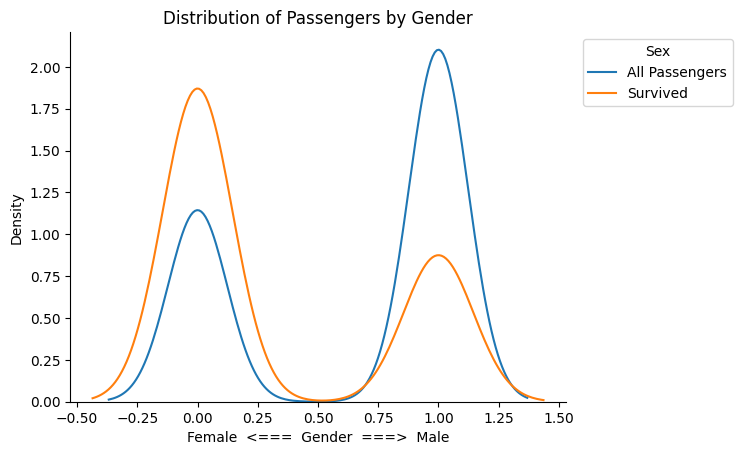

In [47]:
#do some viz to understand data and relationships - class and gender should be high for survival rates


#bar chart of men vs women on ship and then bar chart of men vs women that survived
sns.kdeplot(data = train_df, x = 'Sex_cat', label = 'All Passengers')
sns.kdeplot(data = train_df.loc[train_df['Survived'] == 1], x = 'Sex_cat', label = 'Survived')
plt.legend(bbox_to_anchor = (1.02,1), title = 'Sex')
plt.title('Distribution of Passengers by Gender')
plt.xlabel('Female  <===  Gender  ===>  Male')
plt.ylabel('Density')
sns.despine()
plt.show()


<Axes: >

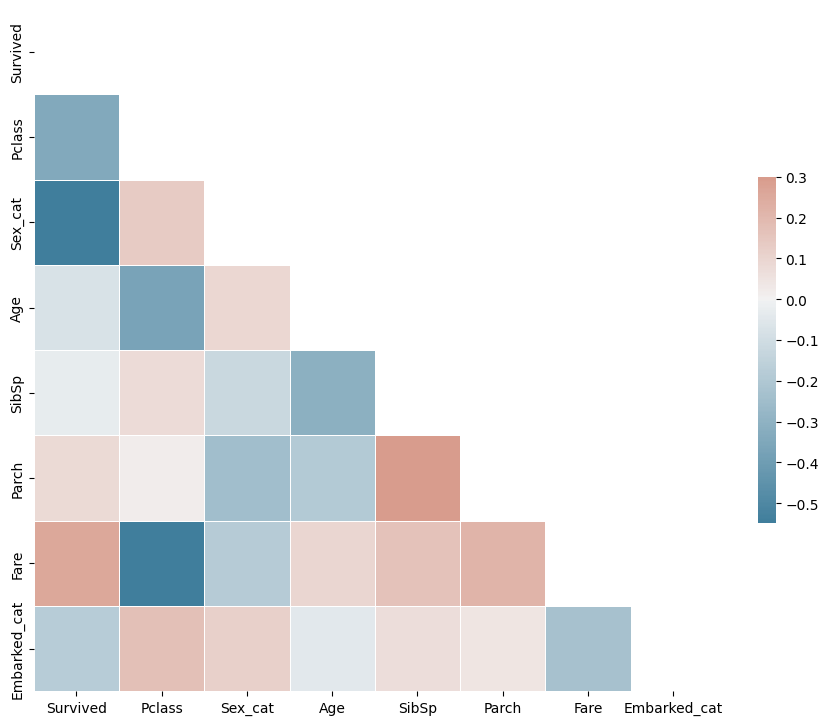

In [48]:
#correlation plot between vars - code from sns correlation plot

# Compute the correlation matrix
corr = train_df[['Survived','Pclass','Sex_cat','Age','SibSp','Parch','Fare','Embarked_cat']].corr()

# Generate a mask for the upper triangle
mask = np.triu(np.ones_like(corr, dtype=bool))

# Set up the matplotlib figure
f, ax = plt.subplots(figsize=(11, 9))

# Generate a custom diverging colormap
cmap = sns.diverging_palette(230, 20, as_cmap=True)

# Draw the heatmap with the mask and correct aspect ratio
sns.heatmap(corr, mask=mask, cmap=cmap, vmax=.3, center=0,
            square=True, linewidths=.5, cbar_kws={"shrink": .5})

#high negative correlations between survival and sex/class (men and low class did not survive) high corr with Fare (upper class survived)
#other correlations involve class and fare (higher class paid more for tickets)


In [140]:
#optuna trials for each model - xgb lgb cb

#build optimization function defining the objective

#define features and target
id_feats = ['PassengerId','Name']
model_feats = ['Pclass','Sex_cat','Age','SibSp','Parch','Fare','Embarked_cat']
target = ['Survived']

#create model dataframe
model_df = train_df[id_feats + model_feats + target].dropna().reset_index()

X = model_df[model_feats]
y = model_df[target]


#define objective function
def objective_xgb(trial, X = X, y = y):

    #split data using train and test split from sklearn 80/20 split
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 123)

    #define parameters to test
    param = {
        'colsample_bytree': trial.suggest_categorical('colsample_bytree', [0.3,0.4,0.5,0.6,0.7,0.8,0.9, 1.0]),
        'learning_rate': trial.suggest_categorical('learning_rate', [0.01,0.03,0.1,0.15,0.2, 0.3]),
        'n_estimators': 1000,
        'max_depth': trial.suggest_categorical('max_depth', [2,3,4,5,6]),
        'random_state': trial.suggest_categorical('random_state', [2020]),
        'min_child_weight': trial.suggest_int('min_child_weight', 1, 300),
        'early_stopping_rounds' : 100
    }

    #set model with parameter search space
    model = xgb.XGBClassifier(**param)

    #fit the model
    model.fit(X_train, y_train, eval_set=[(X_test,y_test)],verbose=False)

    #make predictions
    preds = model.predict(X_test)

    #evalutate the model based on mean squared error
    acc = accuracy_score(y_test, preds)

    return acc


#define objective function
def objective_lgb(trial, X = X, y = y):

    #split data using train and test split from sklearn 80/20 split
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 123)

    #define parameters to test
    param = {
        'colsample_bytree': trial.suggest_categorical('colsample_bytree', [0.3,0.4,0.5,0.6,0.7,0.8,0.9, 1.0]),
        'learning_rate': trial.suggest_categorical('learning_rate', [0.01,0.03,0.1,0.15,0.2, 0.3]),
        'n_estimators': 1000,
        'max_depth': trial.suggest_categorical('max_depth', [2,3,4,5,6]),
        'random_state': trial.suggest_categorical('random_state', [2020]),
        'min_child_weight': trial.suggest_int('min_child_weight', 1, 300),
        'early_stopping_rounds' : 100
    }

    #set model with parameter search space
    model = lgb.LGBMClassifier(**param,verbose = -1)

    #fit the model
    model.fit(X_train, y_train, eval_set=[(X_test,y_test)])

    #make predictions
    preds = model.predict(X_test)

    #evalutate the model based on mean squared error
    acc = accuracy_score(y_test, preds)

    return acc

#define objective function
def objective_cb(trial, X = X, y = y):

    #split data using train and test split from sklearn 80/20 split
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 123)

    #define parameters to test
    param = {
        # 'colsample_bytree': trial.suggest_categorical('colsample_bytree', [0.3,0.4,0.5,0.6,0.7,0.8,0.9, 1.0]),
        'learning_rate': trial.suggest_categorical('learning_rate', [0.01,0.03,0.1,0.15,0.2, 0.3]),
        'n_estimators': 1000,
        'max_depth': trial.suggest_categorical('max_depth', [2,3,4,5,6]),
        'random_state': trial.suggest_categorical('random_state', [2020]),
        # 'min_child_weight': trial.suggest_int('min_child_weight', 1, 300),
        'early_stopping_rounds' : 100
    }

    #set model with parameter search space
    model = cb.CatBoostClassifier(**param)

    #fit the model
    model.fit(X_train, y_train, eval_set=[(X_test,y_test)],verbose=False)

    #make predictions
    preds = model.predict(X_test)

    #evalutate the model based on mean squared error
    acc = accuracy_score(y_test, preds)

    return acc


In [131]:
#build out the optuna parameter search study
study_xgb = optuna.create_study(direction='maximize') #objective is to maximize accuracy
study_xgb.optimize(objective_xgb, n_trials = 30) #10 trails to be completed
print('Number of finished trials:', len(study_xgb.trials))
print('Best trial:', study_xgb.best_trial.params)

[I 2024-07-12 00:27:30,543] A new study created in memory with name: no-name-77e50442-e0f8-4f48-ba2c-9cfab450778d
[I 2024-07-12 00:27:30,645] Trial 0 finished with value: 0.6083916083916084 and parameters: {'colsample_bytree': 0.7, 'learning_rate': 0.2, 'max_depth': 6, 'random_state': 2020, 'min_child_weight': 276}. Best is trial 0 with value: 0.6083916083916084.
[I 2024-07-12 00:27:31,563] Trial 1 finished with value: 0.6083916083916084 and parameters: {'colsample_bytree': 0.5, 'learning_rate': 0.1, 'max_depth': 2, 'random_state': 2020, 'min_child_weight': 84}. Best is trial 0 with value: 0.6083916083916084.
[I 2024-07-12 00:27:31,621] Trial 2 finished with value: 0.6083916083916084 and parameters: {'colsample_bytree': 0.9, 'learning_rate': 0.3, 'max_depth': 3, 'random_state': 2020, 'min_child_weight': 282}. Best is trial 0 with value: 0.6083916083916084.
[I 2024-07-12 00:27:31,705] Trial 3 finished with value: 0.6083916083916084 and parameters: {'colsample_bytree': 0.4, 'learning_rat

Number of finished trials: 30
Best trial: {'colsample_bytree': 0.8, 'learning_rate': 0.15, 'max_depth': 4, 'random_state': 2020, 'min_child_weight': 1}


In [139]:
#looping through studies for each model
studies = {}
best_trial = {}

for model in ['xgb', 'lgb', 'cb']:
    study_name = 'study_{}'.format(model)
    if model == 'xgb':
        objective = objective_xgb
    elif model == 'lgb':
        objective = objective_lgb
    elif model == 'cb':
        objective = objective_cb

    study = optuna.create_study(direction='maximize')  #maximize accuracy
    study.optimize(objective, n_trials=30)  # 30 trials to be completed
    print('Number of finished trials for {}:'.format(model), len(study.trials))
    print('Best trial for {}:'.format(model), study.best_trial.params)

    studies[study_name] = study
    best_trial[model] = study.best_trial.params


[I 2024-07-12 00:32:31,273] A new study created in memory with name: no-name-bfbda980-1b55-4362-88d7-e8b84cd9c09e


[0]	validation_0-logloss:0.67020
[1]	validation_0-logloss:0.67019
[2]	validation_0-logloss:0.67018
[3]	validation_0-logloss:0.67017
[4]	validation_0-logloss:0.67016
[5]	validation_0-logloss:0.67016
[6]	validation_0-logloss:0.67016
[7]	validation_0-logloss:0.67015
[8]	validation_0-logloss:0.67015
[9]	validation_0-logloss:0.67015
[10]	validation_0-logloss:0.67015
[11]	validation_0-logloss:0.67015
[12]	validation_0-logloss:0.67015
[13]	validation_0-logloss:0.67015
[14]	validation_0-logloss:0.67015
[15]	validation_0-logloss:0.67015
[16]	validation_0-logloss:0.67015
[17]	validation_0-logloss:0.67015
[18]	validation_0-logloss:0.67015
[19]	validation_0-logloss:0.67015
[20]	validation_0-logloss:0.67015
[21]	validation_0-logloss:0.67015
[22]	validation_0-logloss:0.67015
[23]	validation_0-logloss:0.67015
[24]	validation_0-logloss:0.67015
[25]	validation_0-logloss:0.67015
[26]	validation_0-logloss:0.67015
[27]	validation_0-logloss:0.67015
[28]	validation_0-logloss:0.67015
[29]	validation_0-loglos

/usr/local/lib/python3.10/dist-packages/xgboost/core.py:160: UserWarning: [00:32:31] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "verbose" } are not used.

  warnings.warn(smsg, UserWarning)


[46]	validation_0-logloss:0.67015
[47]	validation_0-logloss:0.67015
[48]	validation_0-logloss:0.67015
[49]	validation_0-logloss:0.67015
[50]	validation_0-logloss:0.67015
[51]	validation_0-logloss:0.67015
[52]	validation_0-logloss:0.67015
[53]	validation_0-logloss:0.67015
[54]	validation_0-logloss:0.67015
[55]	validation_0-logloss:0.67015
[56]	validation_0-logloss:0.67015
[57]	validation_0-logloss:0.67015
[58]	validation_0-logloss:0.67015
[59]	validation_0-logloss:0.67015
[60]	validation_0-logloss:0.67015
[61]	validation_0-logloss:0.67015
[62]	validation_0-logloss:0.67015
[63]	validation_0-logloss:0.67015
[64]	validation_0-logloss:0.67015
[65]	validation_0-logloss:0.67015
[66]	validation_0-logloss:0.67015
[67]	validation_0-logloss:0.67015
[68]	validation_0-logloss:0.67015
[69]	validation_0-logloss:0.67015
[70]	validation_0-logloss:0.67015
[71]	validation_0-logloss:0.67015
[72]	validation_0-logloss:0.67015
[73]	validation_0-logloss:0.67015
[74]	validation_0-logloss:0.67015
[75]	validatio

[I 2024-07-12 00:32:31,883] Trial 0 finished with value: 0.6083916083916084 and parameters: {'colsample_bytree': 0.8, 'learning_rate': 0.3, 'max_depth': 3, 'random_state': 2020, 'min_child_weight': 78}. Best is trial 0 with value: 0.6083916083916084.


[0]	validation_0-logloss:0.67022
[1]	validation_0-logloss:0.67022
[2]	validation_0-logloss:0.67022
[3]	validation_0-logloss:0.67022
[4]	validation_0-logloss:0.67022
[5]	validation_0-logloss:0.67022
[6]	validation_0-logloss:0.67022
[7]	validation_0-logloss:0.67022
[8]	validation_0-logloss:0.67022
[9]	validation_0-logloss:0.67022
[10]	validation_0-logloss:0.67022
[11]	validation_0-logloss:0.67022
[12]	validation_0-logloss:0.67022
[13]	validation_0-logloss:0.67022
[14]	validation_0-logloss:0.67022
[15]	validation_0-logloss:0.67022
[16]	validation_0-logloss:0.67022
[17]	validation_0-logloss:0.67022
[18]	validation_0-logloss:0.67022
[19]	validation_0-logloss:0.67022
[20]	validation_0-logloss:0.67022
[21]	validation_0-logloss:0.67022
[22]	validation_0-logloss:0.67022
[23]	validation_0-logloss:0.67022
[24]	validation_0-logloss:0.67022
[25]	validation_0-logloss:0.67022
[26]	validation_0-logloss:0.67022
[27]	validation_0-logloss:0.67022
[28]	validation_0-logloss:0.67022
[29]	validation_0-loglos

/usr/local/lib/python3.10/dist-packages/xgboost/core.py:160: UserWarning: [00:32:31] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "verbose" } are not used.

  warnings.warn(smsg, UserWarning)


[30]	validation_0-logloss:0.67022
[31]	validation_0-logloss:0.67022
[32]	validation_0-logloss:0.67022
[33]	validation_0-logloss:0.67022
[34]	validation_0-logloss:0.67022
[35]	validation_0-logloss:0.67022
[36]	validation_0-logloss:0.67022
[37]	validation_0-logloss:0.67022
[38]	validation_0-logloss:0.67022
[39]	validation_0-logloss:0.67022
[40]	validation_0-logloss:0.67022
[41]	validation_0-logloss:0.67022
[42]	validation_0-logloss:0.67022
[43]	validation_0-logloss:0.67022
[44]	validation_0-logloss:0.67022
[45]	validation_0-logloss:0.67022
[46]	validation_0-logloss:0.67022
[47]	validation_0-logloss:0.67022
[48]	validation_0-logloss:0.67022
[49]	validation_0-logloss:0.67022
[50]	validation_0-logloss:0.67022
[51]	validation_0-logloss:0.67022
[52]	validation_0-logloss:0.67022
[53]	validation_0-logloss:0.67022
[54]	validation_0-logloss:0.67022
[55]	validation_0-logloss:0.67022
[56]	validation_0-logloss:0.67022
[57]	validation_0-logloss:0.67022
[58]	validation_0-logloss:0.67022
[59]	validatio

[I 2024-07-12 00:32:32,450] Trial 1 finished with value: 0.6083916083916084 and parameters: {'colsample_bytree': 0.6, 'learning_rate': 0.1, 'max_depth': 5, 'random_state': 2020, 'min_child_weight': 201}. Best is trial 0 with value: 0.6083916083916084.


[0]	validation_0-logloss:0.67022
[1]	validation_0-logloss:0.67022
[2]	validation_0-logloss:0.67022
[3]	validation_0-logloss:0.67022
[4]	validation_0-logloss:0.67022
[5]	validation_0-logloss:0.67022
[6]	validation_0-logloss:0.67022
[7]	validation_0-logloss:0.67022
[8]	validation_0-logloss:0.67022
[9]	validation_0-logloss:0.67022
[10]	validation_0-logloss:0.67022
[11]	validation_0-logloss:0.67022
[12]	validation_0-logloss:0.67022
[13]	validation_0-logloss:0.67022
[14]	validation_0-logloss:0.67022
[15]	validation_0-logloss:0.67022
[16]	validation_0-logloss:0.67022
[17]	validation_0-logloss:0.67022
[18]	validation_0-logloss:0.67022
[19]	validation_0-logloss:0.67022
[20]	validation_0-logloss:0.67022
[21]	validation_0-logloss:0.67022
[22]	validation_0-logloss:0.67022
[23]	validation_0-logloss:0.67022
[24]	validation_0-logloss:0.67022
[25]	validation_0-logloss:0.67022
[26]	validation_0-logloss:0.67022
[27]	validation_0-logloss:0.67022
[28]	validation_0-logloss:0.67022
[29]	validation_0-loglos

/usr/local/lib/python3.10/dist-packages/xgboost/core.py:160: UserWarning: [00:32:32] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "verbose" } are not used.

  warnings.warn(smsg, UserWarning)


[36]	validation_0-logloss:0.67022
[37]	validation_0-logloss:0.67022
[38]	validation_0-logloss:0.67022
[39]	validation_0-logloss:0.67022
[40]	validation_0-logloss:0.67022
[41]	validation_0-logloss:0.67022
[42]	validation_0-logloss:0.67022
[43]	validation_0-logloss:0.67022
[44]	validation_0-logloss:0.67022
[45]	validation_0-logloss:0.67022
[46]	validation_0-logloss:0.67022
[47]	validation_0-logloss:0.67022
[48]	validation_0-logloss:0.67022
[49]	validation_0-logloss:0.67022
[50]	validation_0-logloss:0.67022
[51]	validation_0-logloss:0.67022
[52]	validation_0-logloss:0.67022
[53]	validation_0-logloss:0.67022
[54]	validation_0-logloss:0.67022
[55]	validation_0-logloss:0.67022
[56]	validation_0-logloss:0.67022
[57]	validation_0-logloss:0.67022
[58]	validation_0-logloss:0.67022
[59]	validation_0-logloss:0.67022
[60]	validation_0-logloss:0.67022
[61]	validation_0-logloss:0.67022
[62]	validation_0-logloss:0.67022
[63]	validation_0-logloss:0.67022
[64]	validation_0-logloss:0.67022
[65]	validatio

[I 2024-07-12 00:32:32,987] Trial 2 finished with value: 0.6083916083916084 and parameters: {'colsample_bytree': 0.6, 'learning_rate': 0.03, 'max_depth': 6, 'random_state': 2020, 'min_child_weight': 240}. Best is trial 0 with value: 0.6083916083916084.


[0]	validation_0-logloss:0.67022
[1]	validation_0-logloss:0.67021
[2]	validation_0-logloss:0.67020
[3]	validation_0-logloss:0.67020
[4]	validation_0-logloss:0.67019
[5]	validation_0-logloss:0.67019
[6]	validation_0-logloss:0.67019
[7]	validation_0-logloss:0.67018
[8]	validation_0-logloss:0.67018
[9]	validation_0-logloss:0.67018
[10]	validation_0-logloss:0.67017
[11]	validation_0-logloss:0.67017
[12]	validation_0-logloss:0.67017
[13]	validation_0-logloss:0.67017
[14]	validation_0-logloss:0.67017
[15]	validation_0-logloss:0.67016
[16]	validation_0-logloss:0.67016
[17]	validation_0-logloss:0.67016
[18]	validation_0-logloss:0.67016


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:160: UserWarning: [00:32:33] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "verbose" } are not used.

  warnings.warn(smsg, UserWarning)


[19]	validation_0-logloss:0.67016
[20]	validation_0-logloss:0.67016
[21]	validation_0-logloss:0.67016
[22]	validation_0-logloss:0.67016
[23]	validation_0-logloss:0.67016
[24]	validation_0-logloss:0.67016
[25]	validation_0-logloss:0.67015
[26]	validation_0-logloss:0.67015
[27]	validation_0-logloss:0.67015
[28]	validation_0-logloss:0.67015
[29]	validation_0-logloss:0.67015
[30]	validation_0-logloss:0.67015
[31]	validation_0-logloss:0.67015
[32]	validation_0-logloss:0.67015
[33]	validation_0-logloss:0.67015
[34]	validation_0-logloss:0.67015
[35]	validation_0-logloss:0.67015
[36]	validation_0-logloss:0.67015
[37]	validation_0-logloss:0.67015
[38]	validation_0-logloss:0.67015
[39]	validation_0-logloss:0.67015
[40]	validation_0-logloss:0.67015
[41]	validation_0-logloss:0.67015
[42]	validation_0-logloss:0.67015
[43]	validation_0-logloss:0.67015
[44]	validation_0-logloss:0.67015
[45]	validation_0-logloss:0.67015
[46]	validation_0-logloss:0.67015
[47]	validation_0-logloss:0.67015
[48]	validatio

[I 2024-07-12 00:32:34,035] Trial 3 finished with value: 0.6083916083916084 and parameters: {'colsample_bytree': 1.0, 'learning_rate': 0.1, 'max_depth': 4, 'random_state': 2020, 'min_child_weight': 75}. Best is trial 0 with value: 0.6083916083916084.


[0]	validation_0-logloss:0.60759
[1]	validation_0-logloss:0.57361
[2]	validation_0-logloss:0.55932
[3]	validation_0-logloss:0.55257
[4]	validation_0-logloss:0.53716
[5]	validation_0-logloss:0.53293
[6]	validation_0-logloss:0.51617
[7]	validation_0-logloss:0.51077
[8]	validation_0-logloss:0.50361
[9]	validation_0-logloss:0.49877
[10]	validation_0-logloss:0.48564
[11]	validation_0-logloss:0.48135
[12]	validation_0-logloss:0.47654
[13]	validation_0-logloss:0.47665
[14]	validation_0-logloss:0.47365
[15]	validation_0-logloss:0.46740
[16]	validation_0-logloss:0.46399
[17]	validation_0-logloss:0.46077
[18]	validation_0-logloss:0.45736
[19]	validation_0-logloss:0.45540
[20]	validation_0-logloss:0.45490
[21]	validation_0-logloss:0.45278
[22]	validation_0-logloss:0.45264
[23]	validation_0-logloss:0.45241
[24]	validation_0-logloss:0.45035
[25]	validation_0-logloss:0.44570
[26]	validation_0-logloss:0.44301
[27]	validation_0-logloss:0.44117


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:160: UserWarning: [00:32:34] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "verbose" } are not used.

  warnings.warn(smsg, UserWarning)


[28]	validation_0-logloss:0.44131
[29]	validation_0-logloss:0.43850
[30]	validation_0-logloss:0.43728
[31]	validation_0-logloss:0.43403
[32]	validation_0-logloss:0.43152
[33]	validation_0-logloss:0.42897
[34]	validation_0-logloss:0.42772
[35]	validation_0-logloss:0.42637
[36]	validation_0-logloss:0.42696
[37]	validation_0-logloss:0.42424
[38]	validation_0-logloss:0.42440
[39]	validation_0-logloss:0.42341
[40]	validation_0-logloss:0.42475
[41]	validation_0-logloss:0.42326
[42]	validation_0-logloss:0.42275
[43]	validation_0-logloss:0.42117
[44]	validation_0-logloss:0.42077
[45]	validation_0-logloss:0.42307
[46]	validation_0-logloss:0.42268
[47]	validation_0-logloss:0.42045
[48]	validation_0-logloss:0.42096
[49]	validation_0-logloss:0.42119
[50]	validation_0-logloss:0.42108
[51]	validation_0-logloss:0.41979
[52]	validation_0-logloss:0.42054
[53]	validation_0-logloss:0.41873
[54]	validation_0-logloss:0.41696
[55]	validation_0-logloss:0.41574
[56]	validation_0-logloss:0.41437
[57]	validatio

[I 2024-07-12 00:32:35,089] Trial 4 finished with value: 0.8391608391608392 and parameters: {'colsample_bytree': 0.6, 'learning_rate': 0.2, 'max_depth': 3, 'random_state': 2020, 'min_child_weight': 4}. Best is trial 4 with value: 0.8391608391608392.


[0]	validation_0-logloss:0.66259
[1]	validation_0-logloss:0.66040
[2]	validation_0-logloss:0.65837
[3]	validation_0-logloss:0.65643
[4]	validation_0-logloss:0.64955
[5]	validation_0-logloss:0.64945
[6]	validation_0-logloss:0.64945
[7]	validation_0-logloss:0.64304
[8]	validation_0-logloss:0.64137
[9]	validation_0-logloss:0.63983
[10]	validation_0-logloss:0.63389
[11]	validation_0-logloss:0.62841
[12]	validation_0-logloss:0.62851
[13]	validation_0-logloss:0.62719
[14]	validation_0-logloss:0.62184
[15]	validation_0-logloss:0.62192
[16]	validation_0-logloss:0.61955
[17]	validation_0-logloss:0.61955
[18]	validation_0-logloss:0.61955
[19]	validation_0-logloss:0.61732
[20]	validation_0-logloss:0.61733
[21]	validation_0-logloss:0.61631
[22]	validation_0-logloss:0.61528
[23]	validation_0-logloss:0.61530
[24]	validation_0-logloss:0.61530
[25]	validation_0-logloss:0.61070
[26]	validation_0-logloss:0.60878
[27]	validation_0-logloss:0.60450
[28]	validation_0-logloss:0.60050
[29]	validation_0-loglos

/usr/local/lib/python3.10/dist-packages/xgboost/core.py:160: UserWarning: [00:32:35] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "verbose" } are not used.

  warnings.warn(smsg, UserWarning)


[32]	validation_0-logloss:0.59505
[33]	validation_0-logloss:0.59140
[34]	validation_0-logloss:0.58976
[35]	validation_0-logloss:0.58976
[36]	validation_0-logloss:0.58902
[37]	validation_0-logloss:0.58855
[38]	validation_0-logloss:0.58707
[39]	validation_0-logloss:0.58568
[40]	validation_0-logloss:0.58436
[41]	validation_0-logloss:0.58122
[42]	validation_0-logloss:0.57816
[43]	validation_0-logloss:0.57538
[44]	validation_0-logloss:0.57279
[45]	validation_0-logloss:0.57158
[46]	validation_0-logloss:0.56915
[47]	validation_0-logloss:0.56870
[48]	validation_0-logloss:0.56875
[49]	validation_0-logloss:0.56834
[50]	validation_0-logloss:0.56611
[51]	validation_0-logloss:0.56604
[52]	validation_0-logloss:0.56396
[53]	validation_0-logloss:0.56401
[54]	validation_0-logloss:0.56405
[55]	validation_0-logloss:0.56405
[56]	validation_0-logloss:0.56296
[57]	validation_0-logloss:0.56193
[58]	validation_0-logloss:0.56161
[59]	validation_0-logloss:0.55969
[60]	validation_0-logloss:0.55790
[61]	validatio

[I 2024-07-12 00:32:36,462] Trial 5 finished with value: 0.7482517482517482 and parameters: {'colsample_bytree': 0.3, 'learning_rate': 0.03, 'max_depth': 5, 'random_state': 2020, 'min_child_weight': 39}. Best is trial 4 with value: 0.8391608391608392.


[0]	validation_0-logloss:0.67022
[1]	validation_0-logloss:0.67022
[2]	validation_0-logloss:0.67022
[3]	validation_0-logloss:0.67022
[4]	validation_0-logloss:0.67022
[5]	validation_0-logloss:0.67022
[6]	validation_0-logloss:0.67022
[7]	validation_0-logloss:0.67022
[8]	validation_0-logloss:0.67022
[9]	validation_0-logloss:0.67022
[10]	validation_0-logloss:0.67022
[11]	validation_0-logloss:0.67022
[12]	validation_0-logloss:0.67022
[13]	validation_0-logloss:0.67022
[14]	validation_0-logloss:0.67022
[15]	validation_0-logloss:0.67022
[16]	validation_0-logloss:0.67022
[17]	validation_0-logloss:0.67022
[18]	validation_0-logloss:0.67022
[19]	validation_0-logloss:0.67022
[20]	validation_0-logloss:0.67022
[21]	validation_0-logloss:0.67022
[22]	validation_0-logloss:0.67022
[23]	validation_0-logloss:0.67022
[24]	validation_0-logloss:0.67022
[25]	validation_0-logloss:0.67022
[26]	validation_0-logloss:0.67022
[27]	validation_0-logloss:0.67022
[28]	validation_0-logloss:0.67022
[29]	validation_0-loglos

/usr/local/lib/python3.10/dist-packages/xgboost/core.py:160: UserWarning: [00:32:36] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "verbose" } are not used.

  warnings.warn(smsg, UserWarning)


[37]	validation_0-logloss:0.67022
[38]	validation_0-logloss:0.67022
[39]	validation_0-logloss:0.67022
[40]	validation_0-logloss:0.67022
[41]	validation_0-logloss:0.67022
[42]	validation_0-logloss:0.67022
[43]	validation_0-logloss:0.67022
[44]	validation_0-logloss:0.67022
[45]	validation_0-logloss:0.67022
[46]	validation_0-logloss:0.67022
[47]	validation_0-logloss:0.67022
[48]	validation_0-logloss:0.67022
[49]	validation_0-logloss:0.67022
[50]	validation_0-logloss:0.67022
[51]	validation_0-logloss:0.67022
[52]	validation_0-logloss:0.67022
[53]	validation_0-logloss:0.67022
[54]	validation_0-logloss:0.67022
[55]	validation_0-logloss:0.67022
[56]	validation_0-logloss:0.67022
[57]	validation_0-logloss:0.67022
[58]	validation_0-logloss:0.67022
[59]	validation_0-logloss:0.67022
[60]	validation_0-logloss:0.67022
[61]	validation_0-logloss:0.67022
[62]	validation_0-logloss:0.67022
[63]	validation_0-logloss:0.67022
[64]	validation_0-logloss:0.67022
[65]	validation_0-logloss:0.67022
[66]	validatio

[I 2024-07-12 00:32:37,132] Trial 6 finished with value: 0.6083916083916084 and parameters: {'colsample_bytree': 0.9, 'learning_rate': 0.2, 'max_depth': 2, 'random_state': 2020, 'min_child_weight': 202}. Best is trial 4 with value: 0.8391608391608392.


[0]	validation_0-logloss:0.67022
[1]	validation_0-logloss:0.67022
[2]	validation_0-logloss:0.67022
[3]	validation_0-logloss:0.67022
[4]	validation_0-logloss:0.67022
[5]	validation_0-logloss:0.67022
[6]	validation_0-logloss:0.67022
[7]	validation_0-logloss:0.67022
[8]	validation_0-logloss:0.67022
[9]	validation_0-logloss:0.67022
[10]	validation_0-logloss:0.67022
[11]	validation_0-logloss:0.67022
[12]	validation_0-logloss:0.67022
[13]	validation_0-logloss:0.67022
[14]	validation_0-logloss:0.67022
[15]	validation_0-logloss:0.67022
[16]	validation_0-logloss:0.67022
[17]	validation_0-logloss:0.67022
[18]	validation_0-logloss:0.67022
[19]	validation_0-logloss:0.67022
[20]	validation_0-logloss:0.67022
[21]	validation_0-logloss:0.67022
[22]	validation_0-logloss:0.67022
[23]	validation_0-logloss:0.67022
[24]	validation_0-logloss:0.67022
[25]	validation_0-logloss:0.67022
[26]	validation_0-logloss:0.67022
[27]	validation_0-logloss:0.67022
[28]	validation_0-logloss:0.67022
[29]	validation_0-loglos

/usr/local/lib/python3.10/dist-packages/xgboost/core.py:160: UserWarning: [00:32:37] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "verbose" } are not used.

  warnings.warn(smsg, UserWarning)


[41]	validation_0-logloss:0.67022
[42]	validation_0-logloss:0.67022
[43]	validation_0-logloss:0.67022
[44]	validation_0-logloss:0.67022
[45]	validation_0-logloss:0.67022
[46]	validation_0-logloss:0.67022
[47]	validation_0-logloss:0.67022
[48]	validation_0-logloss:0.67022
[49]	validation_0-logloss:0.67022
[50]	validation_0-logloss:0.67022
[51]	validation_0-logloss:0.67022
[52]	validation_0-logloss:0.67022
[53]	validation_0-logloss:0.67022
[54]	validation_0-logloss:0.67022
[55]	validation_0-logloss:0.67022
[56]	validation_0-logloss:0.67022
[57]	validation_0-logloss:0.67022
[58]	validation_0-logloss:0.67022
[59]	validation_0-logloss:0.67022
[60]	validation_0-logloss:0.67022
[61]	validation_0-logloss:0.67022
[62]	validation_0-logloss:0.67022
[63]	validation_0-logloss:0.67022
[64]	validation_0-logloss:0.67022
[65]	validation_0-logloss:0.67022
[66]	validation_0-logloss:0.67022
[67]	validation_0-logloss:0.67022
[68]	validation_0-logloss:0.67022
[69]	validation_0-logloss:0.67022
[70]	validatio

[I 2024-07-12 00:32:37,643] Trial 7 finished with value: 0.6083916083916084 and parameters: {'colsample_bytree': 1.0, 'learning_rate': 0.03, 'max_depth': 5, 'random_state': 2020, 'min_child_weight': 200}. Best is trial 4 with value: 0.8391608391608392.


[0]	validation_0-logloss:0.66703
[1]	validation_0-logloss:0.66403
[2]	validation_0-logloss:0.66120
[3]	validation_0-logloss:0.65855
[4]	validation_0-logloss:0.65605
[5]	validation_0-logloss:0.65408
[6]	validation_0-logloss:0.65224
[7]	validation_0-logloss:0.65225
[8]	validation_0-logloss:0.65052
[9]	validation_0-logloss:0.64891
[10]	validation_0-logloss:0.64739
[11]	validation_0-logloss:0.64598
[12]	validation_0-logloss:0.64598
[13]	validation_0-logloss:0.64477
[14]	validation_0-logloss:0.64364
[15]	validation_0-logloss:0.64258
[16]	validation_0-logloss:0.64160
[17]	validation_0-logloss:0.64068
[18]	validation_0-logloss:0.63982
[19]	validation_0-logloss:0.63902
[20]	validation_0-logloss:0.63828
[21]	validation_0-logloss:0.63759
[22]	validation_0-logloss:0.63694


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:160: UserWarning: [00:32:37] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "verbose" } are not used.

  warnings.warn(smsg, UserWarning)


[23]	validation_0-logloss:0.63634
[24]	validation_0-logloss:0.63633
[25]	validation_0-logloss:0.63577
[26]	validation_0-logloss:0.63525
[27]	validation_0-logloss:0.63477
[28]	validation_0-logloss:0.63432
[29]	validation_0-logloss:0.63391
[30]	validation_0-logloss:0.63352
[31]	validation_0-logloss:0.63317
[32]	validation_0-logloss:0.63284
[33]	validation_0-logloss:0.63254
[34]	validation_0-logloss:0.63226
[35]	validation_0-logloss:0.63200
[36]	validation_0-logloss:0.63176
[37]	validation_0-logloss:0.63160
[38]	validation_0-logloss:0.63146
[39]	validation_0-logloss:0.63133
[40]	validation_0-logloss:0.63121
[41]	validation_0-logloss:0.63111
[42]	validation_0-logloss:0.63102
[43]	validation_0-logloss:0.63093
[44]	validation_0-logloss:0.63093
[45]	validation_0-logloss:0.63093
[46]	validation_0-logloss:0.63093
[47]	validation_0-logloss:0.63093
[48]	validation_0-logloss:0.63093
[49]	validation_0-logloss:0.63093
[50]	validation_0-logloss:0.63093
[51]	validation_0-logloss:0.63093
[52]	validatio

[I 2024-07-12 00:32:39,844] Trial 8 finished with value: 0.7062937062937062 and parameters: {'colsample_bytree': 0.9, 'learning_rate': 0.03, 'max_depth': 3, 'random_state': 2020, 'min_child_weight': 66}. Best is trial 4 with value: 0.8391608391608392.


[0]	validation_0-logloss:0.67022
[1]	validation_0-logloss:0.67022
[2]	validation_0-logloss:0.67022
[3]	validation_0-logloss:0.67022


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:160: UserWarning: [00:32:39] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "verbose" } are not used.

  warnings.warn(smsg, UserWarning)


[4]	validation_0-logloss:0.67022
[5]	validation_0-logloss:0.67022
[6]	validation_0-logloss:0.67022
[7]	validation_0-logloss:0.67022
[8]	validation_0-logloss:0.67022
[9]	validation_0-logloss:0.67022
[10]	validation_0-logloss:0.67022
[11]	validation_0-logloss:0.67022
[12]	validation_0-logloss:0.67022
[13]	validation_0-logloss:0.67021
[14]	validation_0-logloss:0.67021
[15]	validation_0-logloss:0.67021
[16]	validation_0-logloss:0.67021
[17]	validation_0-logloss:0.67021
[18]	validation_0-logloss:0.67021
[19]	validation_0-logloss:0.67021
[20]	validation_0-logloss:0.67021
[21]	validation_0-logloss:0.67021
[22]	validation_0-logloss:0.67021
[23]	validation_0-logloss:0.67021
[24]	validation_0-logloss:0.67021
[25]	validation_0-logloss:0.67021
[26]	validation_0-logloss:0.67021
[27]	validation_0-logloss:0.67021
[28]	validation_0-logloss:0.67021
[29]	validation_0-logloss:0.67020
[30]	validation_0-logloss:0.67020
[31]	validation_0-logloss:0.67020
[32]	validation_0-logloss:0.67020
[33]	validation_0-lo

[I 2024-07-12 00:32:44,542] Trial 9 finished with value: 0.6083916083916084 and parameters: {'colsample_bytree': 1.0, 'learning_rate': 0.01, 'max_depth': 5, 'random_state': 2020, 'min_child_weight': 79}. Best is trial 4 with value: 0.8391608391608392.


[0]	validation_0-logloss:0.61899


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:160: UserWarning: [00:32:44] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "verbose" } are not used.

  warnings.warn(smsg, UserWarning)


[1]	validation_0-logloss:0.58746
[2]	validation_0-logloss:0.57438
[3]	validation_0-logloss:0.56814
[4]	validation_0-logloss:0.55044
[5]	validation_0-logloss:0.54785
[6]	validation_0-logloss:0.53066
[7]	validation_0-logloss:0.52395
[8]	validation_0-logloss:0.51462
[9]	validation_0-logloss:0.50940
[10]	validation_0-logloss:0.49520
[11]	validation_0-logloss:0.48861
[12]	validation_0-logloss:0.48474
[13]	validation_0-logloss:0.48081
[14]	validation_0-logloss:0.47832
[15]	validation_0-logloss:0.47448
[16]	validation_0-logloss:0.47071
[17]	validation_0-logloss:0.46785
[18]	validation_0-logloss:0.46522
[19]	validation_0-logloss:0.46343
[20]	validation_0-logloss:0.46228
[21]	validation_0-logloss:0.45977
[22]	validation_0-logloss:0.45915
[23]	validation_0-logloss:0.45763
[24]	validation_0-logloss:0.45544
[25]	validation_0-logloss:0.45177
[26]	validation_0-logloss:0.45188
[27]	validation_0-logloss:0.44698
[28]	validation_0-logloss:0.44693
[29]	validation_0-logloss:0.44273
[30]	validation_0-loglo

[I 2024-07-12 00:32:48,592] Trial 10 finished with value: 0.8461538461538461 and parameters: {'colsample_bytree': 0.7, 'learning_rate': 0.15, 'max_depth': 3, 'random_state': 2020, 'min_child_weight': 1}. Best is trial 10 with value: 0.8461538461538461.


[0]	validation_0-logloss:0.61899
[1]	validation_0-logloss:0.58746
[2]	validation_0-logloss:0.57438
[3]	validation_0-logloss:0.56814
[4]	validation_0-logloss:0.55044
[5]	validation_0-logloss:0.54785


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:160: UserWarning: [00:32:48] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "verbose" } are not used.

  warnings.warn(smsg, UserWarning)


[6]	validation_0-logloss:0.53066
[7]	validation_0-logloss:0.52395
[8]	validation_0-logloss:0.51462
[9]	validation_0-logloss:0.50940
[10]	validation_0-logloss:0.49520
[11]	validation_0-logloss:0.48861
[12]	validation_0-logloss:0.48474
[13]	validation_0-logloss:0.48081
[14]	validation_0-logloss:0.47832
[15]	validation_0-logloss:0.47448
[16]	validation_0-logloss:0.47071
[17]	validation_0-logloss:0.46785
[18]	validation_0-logloss:0.46522
[19]	validation_0-logloss:0.46343
[20]	validation_0-logloss:0.46228
[21]	validation_0-logloss:0.45977
[22]	validation_0-logloss:0.45915
[23]	validation_0-logloss:0.45763
[24]	validation_0-logloss:0.45544
[25]	validation_0-logloss:0.45177
[26]	validation_0-logloss:0.45188
[27]	validation_0-logloss:0.44698
[28]	validation_0-logloss:0.44693
[29]	validation_0-logloss:0.44273
[30]	validation_0-logloss:0.44046
[31]	validation_0-logloss:0.43868
[32]	validation_0-logloss:0.43767
[33]	validation_0-logloss:0.43428
[34]	validation_0-logloss:0.43164
[35]	validation_0-

[I 2024-07-12 00:32:49,950] Trial 11 finished with value: 0.8461538461538461 and parameters: {'colsample_bytree': 0.7, 'learning_rate': 0.15, 'max_depth': 3, 'random_state': 2020, 'min_child_weight': 1}. Best is trial 10 with value: 0.8461538461538461.


[0]	validation_0-logloss:0.67021
[1]	validation_0-logloss:0.67020
[2]	validation_0-logloss:0.67020
[3]	validation_0-logloss:0.67019
[4]	validation_0-logloss:0.67018
[5]	validation_0-logloss:0.67018
[6]	validation_0-logloss:0.67017
[7]	validation_0-logloss:0.67017
[8]	validation_0-logloss:0.67017
[9]	validation_0-logloss:0.67016


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:160: UserWarning: [00:32:50] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "verbose" } are not used.

  warnings.warn(smsg, UserWarning)


[10]	validation_0-logloss:0.67016
[11]	validation_0-logloss:0.67016
[12]	validation_0-logloss:0.67016
[13]	validation_0-logloss:0.67016
[14]	validation_0-logloss:0.67016
[15]	validation_0-logloss:0.67016
[16]	validation_0-logloss:0.67015
[17]	validation_0-logloss:0.67015
[18]	validation_0-logloss:0.67015
[19]	validation_0-logloss:0.67015
[20]	validation_0-logloss:0.67015
[21]	validation_0-logloss:0.67015
[22]	validation_0-logloss:0.67015
[23]	validation_0-logloss:0.67015
[24]	validation_0-logloss:0.67015
[25]	validation_0-logloss:0.67015
[26]	validation_0-logloss:0.67015
[27]	validation_0-logloss:0.67015
[28]	validation_0-logloss:0.67015
[29]	validation_0-logloss:0.67015
[30]	validation_0-logloss:0.67015
[31]	validation_0-logloss:0.67015
[32]	validation_0-logloss:0.67015
[33]	validation_0-logloss:0.67015
[34]	validation_0-logloss:0.67015
[35]	validation_0-logloss:0.67015
[36]	validation_0-logloss:0.67015
[37]	validation_0-logloss:0.67015
[38]	validation_0-logloss:0.67015
[39]	validatio

[I 2024-07-12 00:32:51,051] Trial 12 finished with value: 0.6083916083916084 and parameters: {'colsample_bytree': 0.7, 'learning_rate': 0.15, 'max_depth': 3, 'random_state': 2020, 'min_child_weight': 130}. Best is trial 10 with value: 0.8461538461538461.


[0]	validation_0-logloss:0.62104
[1]	validation_0-logloss:0.59175
[2]	validation_0-logloss:0.58021
[3]	validation_0-logloss:0.57373


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:160: UserWarning: [00:32:51] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "verbose" } are not used.

  warnings.warn(smsg, UserWarning)


[4]	validation_0-logloss:0.55822
[5]	validation_0-logloss:0.55570
[6]	validation_0-logloss:0.53855
[7]	validation_0-logloss:0.53136
[8]	validation_0-logloss:0.52491
[9]	validation_0-logloss:0.52282
[10]	validation_0-logloss:0.50870
[11]	validation_0-logloss:0.50242
[12]	validation_0-logloss:0.49920
[13]	validation_0-logloss:0.49603
[14]	validation_0-logloss:0.49334
[15]	validation_0-logloss:0.48682
[16]	validation_0-logloss:0.48049
[17]	validation_0-logloss:0.47958
[18]	validation_0-logloss:0.47823
[19]	validation_0-logloss:0.47514
[20]	validation_0-logloss:0.47503
[21]	validation_0-logloss:0.47294
[22]	validation_0-logloss:0.47136
[23]	validation_0-logloss:0.46963
[24]	validation_0-logloss:0.46846
[25]	validation_0-logloss:0.46354
[26]	validation_0-logloss:0.45961
[27]	validation_0-logloss:0.45516
[28]	validation_0-logloss:0.45494
[29]	validation_0-logloss:0.45109
[30]	validation_0-logloss:0.44922
[31]	validation_0-logloss:0.44805
[32]	validation_0-logloss:0.44576
[33]	validation_0-lo

[I 2024-07-12 00:32:55,577] Trial 13 finished with value: 0.8671328671328671 and parameters: {'colsample_bytree': 0.7, 'learning_rate': 0.15, 'max_depth': 3, 'random_state': 2020, 'min_child_weight': 8}. Best is trial 13 with value: 0.8671328671328671.


[0]	validation_0-logloss:0.67021
[1]	validation_0-logloss:0.67020
[2]	validation_0-logloss:0.67020
[3]	validation_0-logloss:0.67019
[4]	validation_0-logloss:0.67018
[5]	validation_0-logloss:0.67018
[6]	validation_0-logloss:0.67017
[7]	validation_0-logloss:0.67017
[8]	validation_0-logloss:0.67017
[9]	validation_0-logloss:0.67016
[10]	validation_0-logloss:0.67016
[11]	validation_0-logloss:0.67016
[12]	validation_0-logloss:0.67016
[13]	validation_0-logloss:0.67016
[14]	validation_0-logloss:0.67016
[15]	validation_0-logloss:0.67016
[16]	validation_0-logloss:0.67015


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:160: UserWarning: [00:32:55] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "verbose" } are not used.

  warnings.warn(smsg, UserWarning)


[17]	validation_0-logloss:0.67015
[18]	validation_0-logloss:0.67015
[19]	validation_0-logloss:0.67015
[20]	validation_0-logloss:0.67015
[21]	validation_0-logloss:0.67015
[22]	validation_0-logloss:0.67015
[23]	validation_0-logloss:0.67015
[24]	validation_0-logloss:0.67015
[25]	validation_0-logloss:0.67015
[26]	validation_0-logloss:0.67015
[27]	validation_0-logloss:0.67015
[28]	validation_0-logloss:0.67015
[29]	validation_0-logloss:0.67015
[30]	validation_0-logloss:0.67015
[31]	validation_0-logloss:0.67015
[32]	validation_0-logloss:0.67015
[33]	validation_0-logloss:0.67015
[34]	validation_0-logloss:0.67015
[35]	validation_0-logloss:0.67015
[36]	validation_0-logloss:0.67015
[37]	validation_0-logloss:0.67015
[38]	validation_0-logloss:0.67015
[39]	validation_0-logloss:0.67015
[40]	validation_0-logloss:0.67015
[41]	validation_0-logloss:0.67015
[42]	validation_0-logloss:0.67015
[43]	validation_0-logloss:0.67015
[44]	validation_0-logloss:0.67015
[45]	validation_0-logloss:0.67015
[46]	validatio

[I 2024-07-12 00:32:56,651] Trial 14 finished with value: 0.6083916083916084 and parameters: {'colsample_bytree': 0.7, 'learning_rate': 0.15, 'max_depth': 2, 'random_state': 2020, 'min_child_weight': 137}. Best is trial 13 with value: 0.8671328671328671.


[0]	validation_0-logloss:0.63485
[1]	validation_0-logloss:0.62541
[2]	validation_0-logloss:0.61913
[3]	validation_0-logloss:0.61446
[4]	validation_0-logloss:0.59339
[5]	validation_0-logloss:0.59408
[6]	validation_0-logloss:0.59489
[7]	validation_0-logloss:0.58090
[8]	validation_0-logloss:0.57885
[9]	validation_0-logloss:0.57787
[10]	validation_0-logloss:0.56898
[11]	validation_0-logloss:0.56286
[12]	validation_0-logloss:0.56166
[13]	validation_0-logloss:0.56176
[14]	validation_0-logloss:0.55779
[15]	validation_0-logloss:0.55730
[16]	validation_0-logloss:0.55201
[17]	validation_0-logloss:0.55151
[18]	validation_0-logloss:0.55151
[19]	validation_0-logloss:0.54751
[20]	validation_0-logloss:0.54707
[21]	validation_0-logloss:0.54822
[22]	validation_0-logloss:0.54931
[23]	validation_0-logloss:0.54880
[24]	validation_0-logloss:0.54880
[25]	validation_0-logloss:0.54638


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:160: UserWarning: [00:32:56] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "verbose" } are not used.

  warnings.warn(smsg, UserWarning)


[26]	validation_0-logloss:0.54360
[27]	validation_0-logloss:0.54220
[28]	validation_0-logloss:0.54156
[29]	validation_0-logloss:0.54142
[30]	validation_0-logloss:0.53909
[31]	validation_0-logloss:0.53833
[32]	validation_0-logloss:0.53820
[33]	validation_0-logloss:0.53838
[34]	validation_0-logloss:0.53643
[35]	validation_0-logloss:0.53673
[36]	validation_0-logloss:0.53773
[37]	validation_0-logloss:0.53801
[38]	validation_0-logloss:0.53646
[39]	validation_0-logloss:0.53525
[40]	validation_0-logloss:0.53430
[41]	validation_0-logloss:0.53463
[42]	validation_0-logloss:0.53511
[43]	validation_0-logloss:0.53566
[44]	validation_0-logloss:0.53624
[45]	validation_0-logloss:0.53532
[46]	validation_0-logloss:0.53590
[47]	validation_0-logloss:0.53487
[48]	validation_0-logloss:0.53401
[49]	validation_0-logloss:0.53480
[50]	validation_0-logloss:0.53535
[51]	validation_0-logloss:0.53531
[52]	validation_0-logloss:0.53452
[53]	validation_0-logloss:0.53371
[54]	validation_0-logloss:0.53304
[55]	validatio

[I 2024-07-12 00:32:59,207] Trial 15 finished with value: 0.7412587412587412 and parameters: {'colsample_bytree': 0.4, 'learning_rate': 0.15, 'max_depth': 6, 'random_state': 2020, 'min_child_weight': 34}. Best is trial 13 with value: 0.8671328671328671.


[0]	validation_0-logloss:0.67022
[1]	validation_0-logloss:0.67022
[2]	validation_0-logloss:0.67022
[3]	validation_0-logloss:0.67022
[4]	validation_0-logloss:0.67022
[5]	validation_0-logloss:0.67022
[6]	validation_0-logloss:0.67022
[7]	validation_0-logloss:0.67022
[8]	validation_0-logloss:0.67022
[9]	validation_0-logloss:0.67022
[10]	validation_0-logloss:0.67022
[11]	validation_0-logloss:0.67022
[12]	validation_0-logloss:0.67022
[13]	validation_0-logloss:0.67022
[14]	validation_0-logloss:0.67022
[15]	validation_0-logloss:0.67022
[16]	validation_0-logloss:0.67022
[17]	validation_0-logloss:0.67022
[18]	validation_0-logloss:0.67022
[19]	validation_0-logloss:0.67022


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:160: UserWarning: [00:32:59] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "verbose" } are not used.

  warnings.warn(smsg, UserWarning)


[20]	validation_0-logloss:0.67022
[21]	validation_0-logloss:0.67022
[22]	validation_0-logloss:0.67022
[23]	validation_0-logloss:0.67022
[24]	validation_0-logloss:0.67022
[25]	validation_0-logloss:0.67022
[26]	validation_0-logloss:0.67022
[27]	validation_0-logloss:0.67022
[28]	validation_0-logloss:0.67022
[29]	validation_0-logloss:0.67022
[30]	validation_0-logloss:0.67022
[31]	validation_0-logloss:0.67022
[32]	validation_0-logloss:0.67022
[33]	validation_0-logloss:0.67022
[34]	validation_0-logloss:0.67022
[35]	validation_0-logloss:0.67022
[36]	validation_0-logloss:0.67022
[37]	validation_0-logloss:0.67022
[38]	validation_0-logloss:0.67022
[39]	validation_0-logloss:0.67022
[40]	validation_0-logloss:0.67022
[41]	validation_0-logloss:0.67022
[42]	validation_0-logloss:0.67022
[43]	validation_0-logloss:0.67022
[44]	validation_0-logloss:0.67022
[45]	validation_0-logloss:0.67022
[46]	validation_0-logloss:0.67022
[47]	validation_0-logloss:0.67022
[48]	validation_0-logloss:0.67022
[49]	validatio

[I 2024-07-12 00:32:59,922] Trial 16 finished with value: 0.6083916083916084 and parameters: {'colsample_bytree': 0.5, 'learning_rate': 0.15, 'max_depth': 4, 'random_state': 2020, 'min_child_weight': 283}. Best is trial 13 with value: 0.8671328671328671.


[0]	validation_0-logloss:0.67020
[1]	validation_0-logloss:0.67019
[2]	validation_0-logloss:0.67018
[3]	validation_0-logloss:0.67017
[4]	validation_0-logloss:0.67016
[5]	validation_0-logloss:0.67016
[6]	validation_0-logloss:0.67016
[7]	validation_0-logloss:0.67015
[8]	validation_0-logloss:0.67015
[9]	validation_0-logloss:0.67015


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:160: UserWarning: [00:32:59] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "verbose" } are not used.

  warnings.warn(smsg, UserWarning)


[10]	validation_0-logloss:0.67015
[11]	validation_0-logloss:0.67015
[12]	validation_0-logloss:0.67015
[13]	validation_0-logloss:0.67015
[14]	validation_0-logloss:0.67015
[15]	validation_0-logloss:0.67015
[16]	validation_0-logloss:0.67015
[17]	validation_0-logloss:0.67015
[18]	validation_0-logloss:0.67015
[19]	validation_0-logloss:0.67015
[20]	validation_0-logloss:0.67015
[21]	validation_0-logloss:0.67015
[22]	validation_0-logloss:0.67015
[23]	validation_0-logloss:0.67015
[24]	validation_0-logloss:0.67015
[25]	validation_0-logloss:0.67015
[26]	validation_0-logloss:0.67015
[27]	validation_0-logloss:0.67015
[28]	validation_0-logloss:0.67015
[29]	validation_0-logloss:0.67015
[30]	validation_0-logloss:0.67015
[31]	validation_0-logloss:0.67015
[32]	validation_0-logloss:0.67015
[33]	validation_0-logloss:0.67015
[34]	validation_0-logloss:0.67015
[35]	validation_0-logloss:0.67015
[36]	validation_0-logloss:0.67015
[37]	validation_0-logloss:0.67015
[38]	validation_0-logloss:0.67015
[39]	validatio

[I 2024-07-12 00:33:03,872] Trial 17 finished with value: 0.6083916083916084 and parameters: {'colsample_bytree': 0.7, 'learning_rate': 0.3, 'max_depth': 3, 'random_state': 2020, 'min_child_weight': 111}. Best is trial 13 with value: 0.8671328671328671.


[0]	validation_0-logloss:0.66744


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:160: UserWarning: [00:33:04] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "verbose" } are not used.

  warnings.warn(smsg, UserWarning)


[1]	validation_0-logloss:0.66472
[2]	validation_0-logloss:0.66366
[3]	validation_0-logloss:0.66293
[4]	validation_0-logloss:0.66049
[5]	validation_0-logloss:0.65979
[6]	validation_0-logloss:0.65736
[7]	validation_0-logloss:0.65503
[8]	validation_0-logloss:0.65431
[9]	validation_0-logloss:0.65360
[10]	validation_0-logloss:0.65117
[11]	validation_0-logloss:0.64879
[12]	validation_0-logloss:0.64664
[13]	validation_0-logloss:0.64436
[14]	validation_0-logloss:0.64213
[15]	validation_0-logloss:0.64119
[16]	validation_0-logloss:0.64027
[17]	validation_0-logloss:0.63937
[18]	validation_0-logloss:0.63926
[19]	validation_0-logloss:0.63837
[20]	validation_0-logloss:0.63637
[21]	validation_0-logloss:0.63578
[22]	validation_0-logloss:0.63521
[23]	validation_0-logloss:0.63328
[24]	validation_0-logloss:0.63139
[25]	validation_0-logloss:0.62939
[26]	validation_0-logloss:0.62856
[27]	validation_0-logloss:0.62672
[28]	validation_0-logloss:0.62494
[29]	validation_0-logloss:0.62307
[30]	validation_0-loglo

[I 2024-07-12 00:33:08,634] Trial 18 finished with value: 0.7482517482517482 and parameters: {'colsample_bytree': 0.7, 'learning_rate': 0.01, 'max_depth': 3, 'random_state': 2020, 'min_child_weight': 36}. Best is trial 13 with value: 0.8671328671328671.


[0]	validation_0-logloss:0.67022
[1]	validation_0-logloss:0.67022
[2]	validation_0-logloss:0.67022
[3]	validation_0-logloss:0.67022
[4]	validation_0-logloss:0.67022
[5]	validation_0-logloss:0.67022
[6]	validation_0-logloss:0.67022
[7]	validation_0-logloss:0.67022
[8]	validation_0-logloss:0.67022
[9]	validation_0-logloss:0.67022
[10]	validation_0-logloss:0.67022
[11]	validation_0-logloss:0.67022
[12]	validation_0-logloss:0.67022


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:160: UserWarning: [00:33:08] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "verbose" } are not used.

  warnings.warn(smsg, UserWarning)


[13]	validation_0-logloss:0.67022
[14]	validation_0-logloss:0.67022
[15]	validation_0-logloss:0.67022
[16]	validation_0-logloss:0.67022
[17]	validation_0-logloss:0.67022
[18]	validation_0-logloss:0.67022
[19]	validation_0-logloss:0.67022
[20]	validation_0-logloss:0.67022
[21]	validation_0-logloss:0.67022
[22]	validation_0-logloss:0.67022
[23]	validation_0-logloss:0.67022
[24]	validation_0-logloss:0.67022
[25]	validation_0-logloss:0.67022
[26]	validation_0-logloss:0.67022
[27]	validation_0-logloss:0.67022
[28]	validation_0-logloss:0.67022
[29]	validation_0-logloss:0.67022
[30]	validation_0-logloss:0.67022
[31]	validation_0-logloss:0.67022
[32]	validation_0-logloss:0.67022
[33]	validation_0-logloss:0.67022
[34]	validation_0-logloss:0.67022
[35]	validation_0-logloss:0.67022
[36]	validation_0-logloss:0.67022
[37]	validation_0-logloss:0.67022
[38]	validation_0-logloss:0.67022
[39]	validation_0-logloss:0.67022
[40]	validation_0-logloss:0.67022
[41]	validation_0-logloss:0.67022
[42]	validatio

[I 2024-07-12 00:33:09,738] Trial 19 finished with value: 0.6083916083916084 and parameters: {'colsample_bytree': 0.8, 'learning_rate': 0.15, 'max_depth': 3, 'random_state': 2020, 'min_child_weight': 170}. Best is trial 13 with value: 0.8671328671328671.


[0]	validation_0-logloss:0.67021
[1]	validation_0-logloss:0.67020
[2]	validation_0-logloss:0.67020
[3]	validation_0-logloss:0.67019
[4]	validation_0-logloss:0.67018
[5]	validation_0-logloss:0.67018
[6]	validation_0-logloss:0.67017
[7]	validation_0-logloss:0.67017
[8]	validation_0-logloss:0.67017
[9]	validation_0-logloss:0.67016
[10]	validation_0-logloss:0.67016
[11]	validation_0-logloss:0.67016
[12]	validation_0-logloss:0.67016
[13]	validation_0-logloss:0.67016
[14]	validation_0-logloss:0.67016


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:160: UserWarning: [00:33:09] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "verbose" } are not used.

  warnings.warn(smsg, UserWarning)


[15]	validation_0-logloss:0.67016
[16]	validation_0-logloss:0.67015
[17]	validation_0-logloss:0.67015
[18]	validation_0-logloss:0.67015
[19]	validation_0-logloss:0.67015
[20]	validation_0-logloss:0.67015
[21]	validation_0-logloss:0.67015
[22]	validation_0-logloss:0.67015
[23]	validation_0-logloss:0.67015
[24]	validation_0-logloss:0.67015
[25]	validation_0-logloss:0.67015
[26]	validation_0-logloss:0.67015
[27]	validation_0-logloss:0.67015
[28]	validation_0-logloss:0.67015
[29]	validation_0-logloss:0.67015
[30]	validation_0-logloss:0.67015
[31]	validation_0-logloss:0.67015
[32]	validation_0-logloss:0.67015
[33]	validation_0-logloss:0.67015
[34]	validation_0-logloss:0.67015
[35]	validation_0-logloss:0.67015
[36]	validation_0-logloss:0.67015
[37]	validation_0-logloss:0.67015
[38]	validation_0-logloss:0.67015
[39]	validation_0-logloss:0.67015
[40]	validation_0-logloss:0.67015
[41]	validation_0-logloss:0.67015
[42]	validation_0-logloss:0.67015
[43]	validation_0-logloss:0.67015
[44]	validatio

[I 2024-07-12 00:33:10,914] Trial 20 finished with value: 0.6083916083916084 and parameters: {'colsample_bytree': 0.5, 'learning_rate': 0.15, 'max_depth': 2, 'random_state': 2020, 'min_child_weight': 103}. Best is trial 13 with value: 0.8671328671328671.


[0]	validation_0-logloss:0.61899
[1]	validation_0-logloss:0.58746
[2]	validation_0-logloss:0.57438
[3]	validation_0-logloss:0.56814
[4]	validation_0-logloss:0.55044
[5]	validation_0-logloss:0.54785
[6]	validation_0-logloss:0.53066
[7]	validation_0-logloss:0.52395
[8]	validation_0-logloss:0.51462
[9]	validation_0-logloss:0.50940
[10]	validation_0-logloss:0.49520
[11]	validation_0-logloss:0.48861
[12]	validation_0-logloss:0.48474
[13]	validation_0-logloss:0.48081
[14]	validation_0-logloss:0.47832
[15]	validation_0-logloss:0.47448
[16]	validation_0-logloss:0.47071


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:160: UserWarning: [00:33:11] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "verbose" } are not used.

  warnings.warn(smsg, UserWarning)


[17]	validation_0-logloss:0.46785
[18]	validation_0-logloss:0.46522
[19]	validation_0-logloss:0.46343
[20]	validation_0-logloss:0.46228
[21]	validation_0-logloss:0.45977
[22]	validation_0-logloss:0.45915
[23]	validation_0-logloss:0.45763
[24]	validation_0-logloss:0.45544
[25]	validation_0-logloss:0.45177
[26]	validation_0-logloss:0.45188
[27]	validation_0-logloss:0.44698
[28]	validation_0-logloss:0.44693
[29]	validation_0-logloss:0.44273
[30]	validation_0-logloss:0.44046
[31]	validation_0-logloss:0.43868
[32]	validation_0-logloss:0.43767
[33]	validation_0-logloss:0.43428
[34]	validation_0-logloss:0.43164
[35]	validation_0-logloss:0.43170
[36]	validation_0-logloss:0.43124
[37]	validation_0-logloss:0.43133
[38]	validation_0-logloss:0.43060
[39]	validation_0-logloss:0.42875
[40]	validation_0-logloss:0.42807
[41]	validation_0-logloss:0.42582
[42]	validation_0-logloss:0.42502
[43]	validation_0-logloss:0.42438
[44]	validation_0-logloss:0.42518
[45]	validation_0-logloss:0.42470
[46]	validatio

[I 2024-07-12 00:33:12,392] Trial 21 finished with value: 0.8461538461538461 and parameters: {'colsample_bytree': 0.7, 'learning_rate': 0.15, 'max_depth': 3, 'random_state': 2020, 'min_child_weight': 1}. Best is trial 13 with value: 0.8671328671328671.


[0]	validation_0-logloss:0.62117
[1]	validation_0-logloss:0.59503
[2]	validation_0-logloss:0.58538
[3]	validation_0-logloss:0.57864
[4]	validation_0-logloss:0.56204
[5]	validation_0-logloss:0.55878
[6]	validation_0-logloss:0.54185
[7]	validation_0-logloss:0.53358
[8]	validation_0-logloss:0.53329
[9]	validation_0-logloss:0.53233
[10]	validation_0-logloss:0.52237
[11]	validation_0-logloss:0.51852
[12]	validation_0-logloss:0.51603
[13]	validation_0-logloss:0.51557
[14]	validation_0-logloss:0.51535
[15]	validation_0-logloss:0.51292
[16]	validation_0-logloss:0.51187
[17]	validation_0-logloss:0.50906
[18]	validation_0-logloss:0.50940


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:160: UserWarning: [00:33:12] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "verbose" } are not used.

  warnings.warn(smsg, UserWarning)


[19]	validation_0-logloss:0.50763
[20]	validation_0-logloss:0.50742
[21]	validation_0-logloss:0.50566
[22]	validation_0-logloss:0.50582
[23]	validation_0-logloss:0.50594
[24]	validation_0-logloss:0.50631
[25]	validation_0-logloss:0.50686
[26]	validation_0-logloss:0.50586
[27]	validation_0-logloss:0.50643
[28]	validation_0-logloss:0.50706
[29]	validation_0-logloss:0.50475
[30]	validation_0-logloss:0.50271
[31]	validation_0-logloss:0.50167
[32]	validation_0-logloss:0.50091
[33]	validation_0-logloss:0.50086
[34]	validation_0-logloss:0.50040
[35]	validation_0-logloss:0.49868
[36]	validation_0-logloss:0.49935
[37]	validation_0-logloss:0.49834
[38]	validation_0-logloss:0.49668
[39]	validation_0-logloss:0.49734
[40]	validation_0-logloss:0.49710
[41]	validation_0-logloss:0.49760
[42]	validation_0-logloss:0.49589
[43]	validation_0-logloss:0.49642
[44]	validation_0-logloss:0.49558
[45]	validation_0-logloss:0.49474
[46]	validation_0-logloss:0.49602
[47]	validation_0-logloss:0.49340
[48]	validatio

[I 2024-07-12 00:33:20,016] Trial 22 finished with value: 0.8391608391608392 and parameters: {'colsample_bytree': 0.7, 'learning_rate': 0.15, 'max_depth': 3, 'random_state': 2020, 'min_child_weight': 18}. Best is trial 13 with value: 0.8671328671328671.


[0]	validation_0-logloss:0.63485
[1]	validation_0-logloss:0.61035


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:160: UserWarning: [00:33:20] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "verbose" } are not used.

  warnings.warn(smsg, UserWarning)


[2]	validation_0-logloss:0.59679
[3]	validation_0-logloss:0.59155
[4]	validation_0-logloss:0.57581
[5]	validation_0-logloss:0.57155
[6]	validation_0-logloss:0.56111
[7]	validation_0-logloss:0.55393
[8]	validation_0-logloss:0.55415
[9]	validation_0-logloss:0.55496
[10]	validation_0-logloss:0.55045
[11]	validation_0-logloss:0.54758
[12]	validation_0-logloss:0.54756
[13]	validation_0-logloss:0.54698
[14]	validation_0-logloss:0.54731
[15]	validation_0-logloss:0.54227
[16]	validation_0-logloss:0.53845
[17]	validation_0-logloss:0.53554
[18]	validation_0-logloss:0.53536
[19]	validation_0-logloss:0.53305
[20]	validation_0-logloss:0.53305
[21]	validation_0-logloss:0.53338
[22]	validation_0-logloss:0.53374
[23]	validation_0-logloss:0.53403
[24]	validation_0-logloss:0.53392
[25]	validation_0-logloss:0.53224
[26]	validation_0-logloss:0.53095
[27]	validation_0-logloss:0.52995
[28]	validation_0-logloss:0.52994
[29]	validation_0-logloss:0.52917
[30]	validation_0-logloss:0.52899
[31]	validation_0-logl

[I 2024-07-12 00:33:22,921] Trial 23 finished with value: 0.7622377622377622 and parameters: {'colsample_bytree': 0.7, 'learning_rate': 0.15, 'max_depth': 3, 'random_state': 2020, 'min_child_weight': 45}. Best is trial 13 with value: 0.8671328671328671.
/usr/local/lib/python3.10/dist-packages/xgboost/core.py:160: UserWarning: [00:33:23] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "verbose" } are not used.

  warnings.warn(smsg, UserWarning)


[0]	validation_0-logloss:0.63485
[1]	validation_0-logloss:0.62245
[2]	validation_0-logloss:0.61327
[3]	validation_0-logloss:0.60681
[4]	validation_0-logloss:0.58558
[5]	validation_0-logloss:0.58616
[6]	validation_0-logloss:0.58728
[7]	validation_0-logloss:0.57278
[8]	validation_0-logloss:0.56979
[9]	validation_0-logloss:0.56838
[10]	validation_0-logloss:0.55980
[11]	validation_0-logloss:0.55259
[12]	validation_0-logloss:0.55223
[13]	validation_0-logloss:0.55073
[14]	validation_0-logloss:0.54758
[15]	validation_0-logloss:0.54621
[16]	validation_0-logloss:0.54162
[17]	validation_0-logloss:0.54141
[18]	validation_0-logloss:0.54309
[19]	validation_0-logloss:0.54061
[20]	validation_0-logloss:0.54118
[21]	validation_0-logloss:0.54088
[22]	validation_0-logloss:0.53970
[23]	validation_0-logloss:0.53943
[24]	validation_0-logloss:0.54086
[25]	validation_0-logloss:0.53894
[26]	validation_0-logloss:0.53536
[27]	validation_0-logloss:0.53366
[28]	validation_0-logloss:0.53274
[29]	validation_0-loglos

[I 2024-07-12 00:33:34,827] Trial 24 finished with value: 0.8181818181818182 and parameters: {'colsample_bytree': 0.4, 'learning_rate': 0.15, 'max_depth': 3, 'random_state': 2020, 'min_child_weight': 19}. Best is trial 13 with value: 0.8671328671328671.


[0]	validation_0-logloss:0.67021
[1]	validation_0-logloss:0.66121
[2]	validation_0-logloss:0.65317
[3]	validation_0-logloss:0.64757
[4]	validation_0-logloss:0.64756
[5]	validation_0-logloss:0.64756
[6]	validation_0-logloss:0.64755
[7]	validation_0-logloss:0.64755
[8]	validation_0-logloss:0.64660
[9]	validation_0-logloss:0.64369
[10]	validation_0-logloss:0.63544
[11]	validation_0-logloss:0.63544
[12]	validation_0-logloss:0.63540
[13]	validation_0-logloss:0.63395
[14]	validation_0-logloss:0.63465
[15]	validation_0-logloss:0.63429
[16]	validation_0-logloss:0.62888
[17]	validation_0-logloss:0.62888
[18]	validation_0-logloss:0.62888
[19]	validation_0-logloss:0.62492
[20]	validation_0-logloss:0.62492


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:160: UserWarning: [00:33:34] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "verbose" } are not used.

  warnings.warn(smsg, UserWarning)


[21]	validation_0-logloss:0.62501
[22]	validation_0-logloss:0.62583
[23]	validation_0-logloss:0.62583
[24]	validation_0-logloss:0.62583
[25]	validation_0-logloss:0.62327
[26]	validation_0-logloss:0.62141
[27]	validation_0-logloss:0.62141
[28]	validation_0-logloss:0.62141
[29]	validation_0-logloss:0.62005
[30]	validation_0-logloss:0.61906
[31]	validation_0-logloss:0.61906
[32]	validation_0-logloss:0.61813
[33]	validation_0-logloss:0.61838
[34]	validation_0-logloss:0.61763
[35]	validation_0-logloss:0.61761
[36]	validation_0-logloss:0.61782
[37]	validation_0-logloss:0.61724
[38]	validation_0-logloss:0.61662
[39]	validation_0-logloss:0.61617
[40]	validation_0-logloss:0.61585
[41]	validation_0-logloss:0.61592
[42]	validation_0-logloss:0.61558
[43]	validation_0-logloss:0.61558
[44]	validation_0-logloss:0.61558
[45]	validation_0-logloss:0.61529
[46]	validation_0-logloss:0.61529
[47]	validation_0-logloss:0.61497
[48]	validation_0-logloss:0.61497
[49]	validation_0-logloss:0.61472
[50]	validatio

[I 2024-07-12 00:33:37,332] Trial 25 finished with value: 0.6993006993006993 and parameters: {'colsample_bytree': 0.3, 'learning_rate': 0.15, 'max_depth': 6, 'random_state': 2020, 'min_child_weight': 50}. Best is trial 13 with value: 0.8671328671328671.


[0]	validation_0-logloss:0.58145
[1]	validation_0-logloss:0.54226
[2]	validation_0-logloss:0.52894
[3]	validation_0-logloss:0.52842
[4]	validation_0-logloss:0.51607
[5]	validation_0-logloss:0.51336
[6]	validation_0-logloss:0.49704
[7]	validation_0-logloss:0.49500
[8]	validation_0-logloss:0.48313
[9]	validation_0-logloss:0.47571
[10]	validation_0-logloss:0.46184
[11]	validation_0-logloss:0.45769
[12]	validation_0-logloss:0.45191
[13]	validation_0-logloss:0.45073
[14]	validation_0-logloss:0.44965
[15]	validation_0-logloss:0.44344
[16]	validation_0-logloss:0.44016
[17]	validation_0-logloss:0.43751
[18]	validation_0-logloss:0.43546
[19]	validation_0-logloss:0.43268
[20]	validation_0-logloss:0.43232
[21]	validation_0-logloss:0.43140


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:160: UserWarning: [00:33:37] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "verbose" } are not used.

  warnings.warn(smsg, UserWarning)


[22]	validation_0-logloss:0.43071
[23]	validation_0-logloss:0.43036
[24]	validation_0-logloss:0.42788
[25]	validation_0-logloss:0.42405
[26]	validation_0-logloss:0.42074
[27]	validation_0-logloss:0.42017
[28]	validation_0-logloss:0.42075
[29]	validation_0-logloss:0.41792
[30]	validation_0-logloss:0.42119
[31]	validation_0-logloss:0.41793
[32]	validation_0-logloss:0.41700
[33]	validation_0-logloss:0.41777
[34]	validation_0-logloss:0.41675
[35]	validation_0-logloss:0.41474
[36]	validation_0-logloss:0.41245
[37]	validation_0-logloss:0.40982
[38]	validation_0-logloss:0.41047
[39]	validation_0-logloss:0.41120
[40]	validation_0-logloss:0.40966
[41]	validation_0-logloss:0.40880
[42]	validation_0-logloss:0.40881
[43]	validation_0-logloss:0.40985
[44]	validation_0-logloss:0.41193
[45]	validation_0-logloss:0.41059
[46]	validation_0-logloss:0.40925
[47]	validation_0-logloss:0.40910
[48]	validation_0-logloss:0.40816
[49]	validation_0-logloss:0.40923
[50]	validation_0-logloss:0.40871
[51]	validatio

[I 2024-07-12 00:33:38,295] Trial 26 finished with value: 0.8321678321678322 and parameters: {'colsample_bytree': 0.7, 'learning_rate': 0.3, 'max_depth': 4, 'random_state': 2020, 'min_child_weight': 5}. Best is trial 13 with value: 0.8671328671328671.


[0]	validation_0-logloss:0.67022
[1]	validation_0-logloss:0.67022
[2]	validation_0-logloss:0.67022
[3]	validation_0-logloss:0.67022
[4]	validation_0-logloss:0.67022
[5]	validation_0-logloss:0.67022
[6]	validation_0-logloss:0.67022
[7]	validation_0-logloss:0.67022
[8]	validation_0-logloss:0.67022
[9]	validation_0-logloss:0.67022
[10]	validation_0-logloss:0.67022
[11]	validation_0-logloss:0.67022
[12]	validation_0-logloss:0.67022
[13]	validation_0-logloss:0.67021
[14]	validation_0-logloss:0.67021
[15]	validation_0-logloss:0.67021
[16]	validation_0-logloss:0.67021
[17]	validation_0-logloss:0.67021
[18]	validation_0-logloss:0.67021
[19]	validation_0-logloss:0.67021


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:160: UserWarning: [00:33:38] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "verbose" } are not used.

  warnings.warn(smsg, UserWarning)


[20]	validation_0-logloss:0.67021
[21]	validation_0-logloss:0.67021
[22]	validation_0-logloss:0.67021
[23]	validation_0-logloss:0.67021
[24]	validation_0-logloss:0.67021
[25]	validation_0-logloss:0.67021
[26]	validation_0-logloss:0.67021
[27]	validation_0-logloss:0.67021
[28]	validation_0-logloss:0.67021
[29]	validation_0-logloss:0.67020
[30]	validation_0-logloss:0.67020
[31]	validation_0-logloss:0.67020
[32]	validation_0-logloss:0.67020
[33]	validation_0-logloss:0.67020
[34]	validation_0-logloss:0.67020
[35]	validation_0-logloss:0.67020
[36]	validation_0-logloss:0.67020
[37]	validation_0-logloss:0.67020
[38]	validation_0-logloss:0.67020
[39]	validation_0-logloss:0.67020
[40]	validation_0-logloss:0.67020
[41]	validation_0-logloss:0.67020
[42]	validation_0-logloss:0.67020
[43]	validation_0-logloss:0.67020
[44]	validation_0-logloss:0.67020
[45]	validation_0-logloss:0.67020
[46]	validation_0-logloss:0.67020
[47]	validation_0-logloss:0.67020
[48]	validation_0-logloss:0.67020
[49]	validatio

[I 2024-07-12 00:33:43,075] Trial 27 finished with value: 0.6083916083916084 and parameters: {'colsample_bytree': 0.7, 'learning_rate': 0.01, 'max_depth': 3, 'random_state': 2020, 'min_child_weight': 103}. Best is trial 13 with value: 0.8671328671328671.


[0]	validation_0-logloss:0.65087


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:160: UserWarning: [00:33:43] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "verbose" } are not used.

  warnings.warn(smsg, UserWarning)


[1]	validation_0-logloss:0.63992
[2]	validation_0-logloss:0.62975
[3]	validation_0-logloss:0.62444
[4]	validation_0-logloss:0.62443
[5]	validation_0-logloss:0.62125
[6]	validation_0-logloss:0.61664
[7]	validation_0-logloss:0.61663
[8]	validation_0-logloss:0.61591
[9]	validation_0-logloss:0.61571
[10]	validation_0-logloss:0.61348
[11]	validation_0-logloss:0.61328
[12]	validation_0-logloss:0.61180
[13]	validation_0-logloss:0.61086
[14]	validation_0-logloss:0.61026
[15]	validation_0-logloss:0.60989
[16]	validation_0-logloss:0.61014
[17]	validation_0-logloss:0.60997
[18]	validation_0-logloss:0.61021
[19]	validation_0-logloss:0.61009
[20]	validation_0-logloss:0.61009
[21]	validation_0-logloss:0.61039
[22]	validation_0-logloss:0.61069
[23]	validation_0-logloss:0.61090
[24]	validation_0-logloss:0.61084
[25]	validation_0-logloss:0.61094
[26]	validation_0-logloss:0.61121
[27]	validation_0-logloss:0.61138
[28]	validation_0-logloss:0.61138
[29]	validation_0-logloss:0.61162
[30]	validation_0-loglo

[I 2024-07-12 00:33:48,466] Trial 28 finished with value: 0.7062937062937062 and parameters: {'colsample_bytree': 0.7, 'learning_rate': 0.2, 'max_depth': 3, 'random_state': 2020, 'min_child_weight': 56}. Best is trial 13 with value: 0.8671328671328671.


[0]	validation_0-logloss:0.64438
[1]	validation_0-logloss:0.62427
[2]	validation_0-logloss:0.61618
[3]	validation_0-logloss:0.60974
[4]	validation_0-logloss:0.59550
[5]	validation_0-logloss:0.59185
[6]	validation_0-logloss:0.58120
[7]	validation_0-logloss:0.57257
[8]	validation_0-logloss:0.56884
[9]	validation_0-logloss:0.56711
[10]	validation_0-logloss:0.56107
[11]	validation_0-logloss:0.55621
[12]	validation_0-logloss:0.55223
[13]	validation_0-logloss:0.54907
[14]	validation_0-logloss:0.54700
[15]	validation_0-logloss:0.54539
[16]	validation_0-logloss:0.54347
[17]	validation_0-logloss:0.54083
[18]	validation_0-logloss:0.53829
[19]	validation_0-logloss:0.53742
[20]	validation_0-logloss:0.53613


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:160: UserWarning: [00:33:48] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "verbose" } are not used.

  warnings.warn(smsg, UserWarning)


[21]	validation_0-logloss:0.53536
[22]	validation_0-logloss:0.53505
[23]	validation_0-logloss:0.53461
[24]	validation_0-logloss:0.53443
[25]	validation_0-logloss:0.53445
[26]	validation_0-logloss:0.53331
[27]	validation_0-logloss:0.53346
[28]	validation_0-logloss:0.53349
[29]	validation_0-logloss:0.53397
[30]	validation_0-logloss:0.53414
[31]	validation_0-logloss:0.53327
[32]	validation_0-logloss:0.53165
[33]	validation_0-logloss:0.53157
[34]	validation_0-logloss:0.53200
[35]	validation_0-logloss:0.53230
[36]	validation_0-logloss:0.53278
[37]	validation_0-logloss:0.53211
[38]	validation_0-logloss:0.53122
[39]	validation_0-logloss:0.53171
[40]	validation_0-logloss:0.53123
[41]	validation_0-logloss:0.53096
[42]	validation_0-logloss:0.53057
[43]	validation_0-logloss:0.52899
[44]	validation_0-logloss:0.52949
[45]	validation_0-logloss:0.52918
[46]	validation_0-logloss:0.52759
[47]	validation_0-logloss:0.52721
[48]	validation_0-logloss:0.52740
[49]	validation_0-logloss:0.52593
[50]	validatio

[I 2024-07-12 00:33:55,123] Trial 29 finished with value: 0.8041958041958042 and parameters: {'colsample_bytree': 0.8, 'learning_rate': 0.1, 'max_depth': 3, 'random_state': 2020, 'min_child_weight': 23}. Best is trial 13 with value: 0.8671328671328671.
[I 2024-07-12 00:33:55,147] A new study created in memory with name: no-name-7c7111eb-f9dd-45a8-9cfd-1cd0dab80cb0
/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_label.py:99: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_label.py:134: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, dtype=self.classes_.dtype, warn=True)
/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_label.py:134

Number of finished trials for xgb: 30
Best trial for xgb: {'colsample_bytree': 0.7, 'learning_rate': 0.15, 'max_depth': 3, 'random_state': 2020, 'min_child_weight': 8}


/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_label.py:99: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_label.py:134: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, dtype=self.classes_.dtype, warn=True)
/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_label.py:134: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, dtype=self.classes_.dtype, warn=True)
[I 2024-07-12 00:33:55,436] Trial 3 finished with value: 0.7622377622377622 and parameters: {'colsample_bytree': 0.6, 'learning_rate': 0.3, 'max_dept

Number of finished trials for lgb: 30
Best trial for lgb: {'colsample_bytree': 0.5, 'learning_rate': 0.3, 'max_depth': 5, 'random_state': 2020, 'min_child_weight': 1}


[I 2024-07-12 00:33:58,304] Trial 0 finished with value: 0.8461538461538461 and parameters: {'learning_rate': 0.15, 'max_depth': 6, 'random_state': 2020}. Best is trial 0 with value: 0.8461538461538461.
[I 2024-07-12 00:33:59,805] Trial 1 finished with value: 0.8111888111888111 and parameters: {'learning_rate': 0.01, 'max_depth': 2, 'random_state': 2020}. Best is trial 0 with value: 0.8461538461538461.
[I 2024-07-12 00:34:00,339] Trial 2 finished with value: 0.8391608391608392 and parameters: {'learning_rate': 0.1, 'max_depth': 2, 'random_state': 2020}. Best is trial 0 with value: 0.8461538461538461.
[I 2024-07-12 00:34:02,316] Trial 3 finished with value: 0.8601398601398601 and parameters: {'learning_rate': 0.01, 'max_depth': 5, 'random_state': 2020}. Best is trial 3 with value: 0.8601398601398601.
[I 2024-07-12 00:34:04,920] Trial 4 finished with value: 0.8461538461538461 and parameters: {'learning_rate': 0.01, 'max_depth': 6, 'random_state': 2020}. Best is trial 3 with value: 0.8601

Number of finished trials for cb: 30
Best trial for cb: {'learning_rate': 0.01, 'max_depth': 5, 'random_state': 2020}


In [146]:
#view studies and best trials
study_xgb = studies['study_xgb']
study_lgb = studies['study_lgb']
study_cb = studies['study_cb']

print(best_trial['xgb'])
print(best_trial['lgb'])
print(best_trial['cb'])


{'colsample_bytree': 0.7, 'learning_rate': 0.15, 'max_depth': 3, 'random_state': 2020, 'min_child_weight': 8}
{'colsample_bytree': 0.5, 'learning_rate': 0.3, 'max_depth': 5, 'random_state': 2020, 'min_child_weight': 1}
{'learning_rate': 0.01, 'max_depth': 5, 'random_state': 2020}


In [161]:
#do some plotting for each trial

for model in ['xgb', 'lgb', 'cb']:
  fig = optuna.visualization.plot_optimization_history(studies['study_{}'.format(model)])
  fig.update_layout(title=f'Optimization History for {model.upper()}')
  fig.show()

  # parameter importance plot
  fig_2 = optuna.visualization.plot_param_importances(studies['study_{}'.format(model)])
  fig_2.update_layout(title=f'Parameter Importance for {model.upper()}')
  fig_2.show()


In [150]:
optuna.visualization.plot_optimization_history(studies['study_xgb'])

In [162]:
#begin modeling

#identify features and target var
id_feats = ['PassengerId','Name']
model_feats = ['Pclass','Sex_cat','Age','SibSp','Parch','Fare','Embarked_cat']
target = ['Survived']

model_df = train_df[id_feats + model_feats + target].dropna().reset_index()

#small dataset more folds since the model will run fast
folds = 5
kf = KFold(folds, shuffle = True)

#create a series to store model predictions for each model type
xgb_output = pd.Series()
lgb_output = pd.Series()
cb_output = pd.Series()

#create a df to store feature importance of each model
var_imp_df = pd.DataFrame()

#split and run each model across all 5 folds
for train_idx, test_idx in kf.split(model_df):
  train = model_df.iloc[train_idx]
  test = model_df.iloc[test_idx]

  #assign the models
  model_xgb = xgb.XGBClassifier(verbose = False, **best_trial['xgb'])
  model_lgb = lgb.LGBMClassifier(verbose = -1, **best_trial['lgb'])
  model_cb = cb.CatBoostClassifier(verbose = False, **best_trial['cb'])

  #loop through each model type and

  #fit the models to the train data
  model_xgb.fit(train.loc[:, model_feats], train[target])
  model_lgb.fit(train.loc[:, model_feats], train[target])
  model_cb.fit(train.loc[:, model_feats], train[target])

  for model_type in [model_xgb, model_lgb, model_cb]:
  #get feature importance of each model for each fold
    if model_type == model_xgb:
      feature_important = model_type.get_booster().get_score(importance_type='weight')
      keys = list(feature_important.keys())
      values = list(feature_important.values())
      _var_imp_df = pd.DataFrame(data=values, columns=['score'])
      _var_imp_df['feature'] = keys
      _var_imp_df['model'] = 'xgb'
      var_imp_df = pd.concat([var_imp_df, _var_imp_df])

      preds = model_type.predict(test.loc[:, model_feats]) #predict on test data
      idx = test.index #save index of test data to return back to original df
      xgb_series = pd.Series(preds, index=idx) #store predictions and index
      xgb_output = pd.concat([xgb_output, xgb_series]) #join predictions and index into series made out of loop to store all outputs

    elif model_type == model_lgb:
      boost = model_type.booster_
      values = list(boost.feature_importance())
      keys = list(boost.feature_name())
      # print('keys',keys)
      # print('values',values)
      _var_imp_df = pd.DataFrame(data=values, columns=['score'])
      _var_imp_df['feature'] = keys
      _var_imp_df['model'] = 'lgb'
      var_imp_df = pd.concat([var_imp_df, _var_imp_df])

      preds = model_type.predict(test.loc[:, model_feats]) #predict on test data
      idx = test.index #save index of test data to return back to original df
      lgb_series = pd.Series(preds, index=idx) #store predictions and index
      lgb_output = pd.concat([lgb_output, lgb_series]) #join predictions and index into series made out of loop to store all outputs

    else:
      keys = list(model_type.feature_names_)
      values = list(model_type.feature_importances_)
      _var_imp_df = pd.DataFrame(data=values, columns=['score'])
      _var_imp_df['feature'] = keys
      _var_imp_df['model'] = 'cb'
      var_imp_df = pd.concat([var_imp_df, _var_imp_df])

      preds = model_type.predict(test.loc[:, model_feats]) #predict on test data
      idx = test.index #save index of test data to return back to original df
      cb_series = pd.Series(preds, index=idx) #store predictions and index
      cb_output = pd.concat([cb_output, cb_series]) #join predictions and index into series made out of loop to store all outputs



for col in ['xgb', 'lgb', 'cb']:
  # print(eval(col + '_output'))
  model_df['{}_pred'.format(col)] = eval(col + '_output')



/usr/local/lib/python3.10/dist-packages/xgboost/core.py:160: UserWarning:

[00:53:18] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "verbose" } are not used.


/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_label.py:99: DataConversionWarning:

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().

/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_label.py:134: DataConversionWarning:

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().

/usr/local/lib/python3.10/dist-packages/xgboost/core.py:160: UserWarning:

[00:53:19] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "verbose" } are not used.


/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_label.py:99: DataConversionWarning:

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n

/usr/local/lib/python3.10/dist-packages/seaborn/axisgrid.py:718: UserWarning:

Using the barplot function without specifying `order` is likely to produce an incorrect plot.



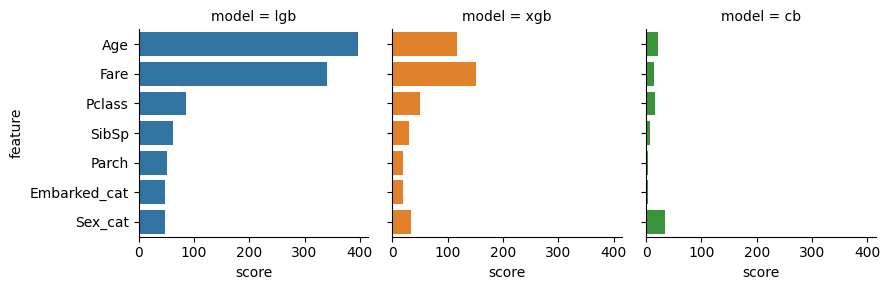

In [163]:
var_imp_summary = var_imp_df.groupby(['model','feature']).mean().sort_values(by = 'score', ascending = False).reset_index()

sns.FacetGrid(data = var_imp_summary, col = 'model', hue = 'model').map(sns.barplot, 'score', 'feature')
plt.show()

In [164]:
model_df.head()

,index,PassengerId,Name,Pclass,Sex_cat,Age,SibSp,Parch,Fare,Embarked_cat,Survived,xgb_pred,lgb_pred,cb_pred
0,0,1,"Braund, Mr. Owen Harris",3,1,22.0,1,0,7.2500,2,0,0,0,0
1,1,2,"Cumings, Mrs. John Bradley (Florence Briggs Th...",1,0,38.0,1,0,71.2833,0,1,1,1,1
2,2,3,"Heikkinen, Miss. Laina",3,0,26.0,0,0,7.9250,2,1,1,0,0
3,3,4,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",1,0,35.0,1,0,53.1000,2,1,1,1,1
4,4,5,"Allen, Mr. William Henry",3,1,35.0,0,0,8.0500,2,0,0,0,0


In [165]:
#check each models accuracy
for col in ['xgb', 'lgb', 'cb']:
  print(col, accuracy_score(model_df['Survived'], model_df['{}_pred'.format(col)]))

xgb 0.8305322128851541
lgb 0.803921568627451
cb 0.8123249299719888


In [180]:
#use my xgb model to predict survivors in the test set

test_preds = model_xgb.predict(test_df[model_feats])
test_df['preds'] = test_preds

#save for kaggle entry
test_df['Survived'] = test_preds



In [181]:
test_df.head()

,PassengerId,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,Embarked_cat,Sex_cat,SibSp_cat,Parch_cat,preds,Survived
0,892,3,"Kelly, Mr. James",male,34.5,0,0,330911,7.8292,NaN,Q,1,1,0,0,0,0
1,893,3,"Wilkes, Mrs. James (Ellen Needs)",female,47.0,1,0,363272,7.0000,NaN,S,2,0,1,0,0,0
2,894,2,"Myles, Mr. Thomas Francis",male,62.0,0,0,240276,9.6875,NaN,Q,1,1,0,0,0,0
3,895,3,"Wirz, Mr. Albert",male,27.0,0,0,315154,8.6625,NaN,S,2,1,0,0,0,0
4,896,3,"Hirvonen, Mrs. Alexander (Helga E Lindqvist)",female,22.0,1,1,3101298,12.2875,NaN,S,2,0,1,1,1,1


In [182]:
test_df[['PassengerId','Survived']].to_csv(project_dir+'/submission.csv', index = False)